In [17]:
### run this first
!pip install -r requirements.txt > /dev/null

import os
import compact_block_debug_parser

debug_file_location='./debug.log'


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


__DISCLAIMER__: I have done my best to summarize this topic as accurately as possible but my knowledge is pretty limited. Corrections/feedback are much appreciated :)

This is an attempt to do a high level walkthrough of the Delving Bitcoin thread [Stats on compact block reconstructions](https://delvingbitcoin.org/t/stats-on-compact-block-reconstructions/1052) created by [0xB10C](https://b10c.me), a bitcoin developer currently focused on monitoring the health of the bitcoin p2p network.

## Compact Block Relay

Compact block relay is a protocol defined by [BIP 52](https://github.com/bitcoin/bips/blob/master/bip-0152.mediawiki) which aims to save bandwidth for nodes during block relay. Previously block relay would include the data for every single tx included in the block, despite the fact that most nodes had already received that tx data and had it available in the mempool. This meant that a high volume of duplicative tx data was being sent between nodes during block relay. Compact block relay defines a way to do block relay without wasting bandwidth sending this duplicative tx data.

## How Does It Work?

1. Node receives new `cmpctblock` message (contains block header, list of txs by ShortID, and prefilled txs)
2. Node collects all the tx data for all txs in the block
3. Node reconstructs the block using the compact block information with the collected tx data
4. Node validates the block
5. Node propogates the block

## Compact Block Reconstruction

Compact block reconstruction refers the process a node goes through to find tx data it already has for the txs (listed by ShortID) contained in the block. After this process, if there is any tx data that is still missing from the block the node will request it from the peer.

A __successful reconstruction__ is when the node had forknowledge of all the txs contained in the `cmpctblock` message and didn't need to request any txs from the peer in order to reconstruct the full block.

## Tx Data Sources

1. Prefilled Txs: txs are sent with the `cmpctblock` message, basically just the coinbase tx since every node will be missing this tx prior to receiving the block
2. Mempool Txs: txs that the node already knows about and has in its mempool
3. Extrapool Txs: txs that the node has already seen and temporarily cached but are not in the mempool (mostly because they have been evicted from the mempool but also possibly because it didn't pass the node's mempool standardness checks), by default this pool only holds up to 100 txs
4. Requested Txs: txs that the node doesn't have and needs to request from its peers (since this is by far the slowest way to source the tx data, the goal is for the requested tx count to be 0)

## Compact Block Reconstruction Rate

This is the percentage of blocks that had a __successful reconstruction__.

The ideal compact block reconstruction rate is 100%, since we want block propogation to be as fast as possible and requesting txs from other nodes is slow.

Below will run some stats avialable to any Bitcoin Core node. If you want to measure your own node's compact block reconstruction metrics change the file location in the cell below to point to your own `debug.log` file location, otherwise just keep the defaults to use the provided sample `debug.log` file.


v---- Run the cell below to set `debug.log` file location ----v

In [18]:
# __NOTE__: if you are using your own `debug.log` file you will need `debug=cmpctblock` 
# option set in your `bitcoin.conf` to get the relevant log lines, and `logtimemicros=1`
# if you want micro second detail

debug_file_location='./debug.log'


## Measure Compact Block Reconstruction Rate!

Apparently the best way to measure this is to just parse the `debug.log` file that lives in the `bitcoin` data directory of bitcoin core nodes. The lines relevant to compact blocks look something like this:

```log
2025-08-01T13:12:57Z Saw new cmpctblock header hash=00000000000000000000fbad28c8fd03ed25137dc9c434f84d90dfbd62c98236 peer=428
2025-08-01T13:12:57Z [cmpctblock] Initialized PartiallyDownloadedBlock for block 00000000000000000000fbad28c8fd03ed25137dc9c434f84d90dfbd62c98236 using a cmpctblock of size 14270
2025-08-01T13:12:57Z [cmpctblock] Initialized PartiallyDownloadedBlock for block 00000000000000000000fbad28c8fd03ed25137dc9c434f84d90dfbd62c98236 using a cmpctblock of size 14270
2025-08-01T13:12:57Z [cmpctblock] Initialized PartiallyDownloadedBlock for block 00000000000000000000fbad28c8fd03ed25137dc9c434f84d90dfbd62c98236 using a cmpctblock of size 14270
2025-08-01T13:12:59Z [cmpctblock] Successfully reconstructed block 00000000000000000000fbad28c8fd03ed25137dc9c434f84d90dfbd62c98236 with 1 txn prefilled, 1205 txn from mempool (incl at least 0 from extra pool) and 1085 txn requested
2025-08-01T13:13:05Z UpdateTip: new best=00000000000000000000fbad28c8fd03ed25137dc9c434f84d90dfbd62c98236 height=908109 version=0x2216a000 log2_work=95.746286 tx=1221179076 date='2025-08-01T13:12:49Z' progress=1.000000 cache=121.8MiB(918190txo)
```

Run the shell script (that was originally taken from a private account on twitter that is supposedly a bitcoin dev) in the cell below (err... so run at your own risk 😅). This will return the compact block reconstruction rate for the most recent blocks.

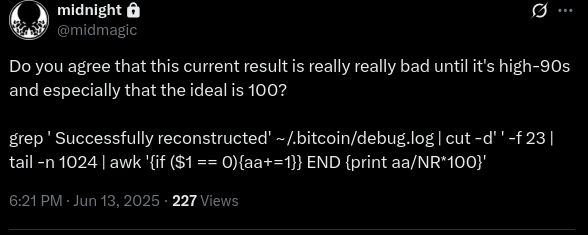  
[source](https://x.com/brian_trollz/status/1934597464276807902)

v---- Run the cell below to get Compact Block Reconstruction Rate ----v

In [19]:

os.environ['CBR_DEBUG_FILE_LOCATION'] = debug_file_location
!grep 'Successfully reconstructed' $CBR_DEBUG_FILE_LOCATION | cut -d' ' -f 23 | tail -n 50 | awk '{if ($1==0){aa+=1}} END {print aa/NR*100}' | python -c 'print("Compact Block Reconstruction Rate: "+input()+"%")'


Compact Block Reconstruction Rate: 36%


## Check Compact Block Reconstruction Stats!

Next, list the latest blocks with a breakdown of their data sources by tx count and the lag time required to reconstruct them.

v---- Run the cell below to get Compact Block Reconstruction Stats ----v

In [20]:

# print compact block stats for the last 50 blocks
compact_block_debug_parser.parse(debug_file_location, 50)


 height             block_abbr         initialized       reconstructed  prefilled  mempool  extrapool  requested  lag_micros
 908064 0000...bc56d41d8eb529c 2025-08-01 05:33:55 2025-08-01 05:33:55          1     3407          9          0           0
 908065 0000...90883aa76e57156 2025-08-01 05:35:55 2025-08-01 05:35:55          1     3162          1          0           0
 908066 0000...525b2b237fc43f2 2025-08-01 05:43:56 2025-08-01 05:43:56          1     2984          0          9           0
 908067 0000...41ac9d2e8ebfbc5 2025-08-01 05:58:14 2025-08-01 05:58:14          1     2508          1          3           0
 908068 0000...7734cba96af4903 2025-08-01 06:04:42 2025-08-01 06:04:42          1     2796          0          3           0
 908069 0000...f82c06d82a4b1b5 2025-08-01 06:09:45 2025-08-01 06:09:46          1     1931          1       1989     1000000
 908070 0000...e7c0ad16f3c558d 2025-08-01 06:31:41 2025-08-01 06:31:41          1     3022          0          0           0


## Whats the Concern?

In [0xB10C](https://b10c.me)'s Delving Bitcoin [post](https://delvingbitcoin.org/t/stats-on-compact-block-reconstructions/1052), they analyze the data that was collected with their various monitoring nodes, which are geographically distributed and each have a different sampling of bitcoin core node configuration options. For each of the monitoring nodes the block reconstruction rate has been tracked over an extended period of time and an overview of the findings is given.

"I observed three periods with a 50% or less “compact block reconstruction without transaction request” rate across all nodes:

End of February till early March
Mid April till early May - especially bad around the halving.
End of May till mid June - especially bad around end of May
This seems to correlate with increasing mempool activity."
-[0xB10C](https://delvingbitcoin.org/t/stats-on-compact-block-reconstructions/1052)

There are also some nice visualizations of the data in the [Delving post](https://delvingbitcoin.org/t/stats-on-compact-block-reconstructions/1052) that I won't repaste here.

## Whats the Cause?

After the initial post there's quite a bit of interest from a number of Bitcoin Core maintainers in understanding where the failure is happening during periods of high mempool activity to cause the reconstruction rate to drop and how it can be improved. Some of the topics covered:
- would increasing extrapool size help? (by default its only 100 txs)
- would making extrapool slightly smarter help? (it seems to just be first in first out)
- would checking the tx orphanage help? maybe some of the missing txs are in there?
- perhaps a lot of this is being caused by out of band transactions?

## More Monitoring

[0xB10C](https://delvingbitcoin.org/t/stats-on-compact-block-reconstructions/1052/24) comes back 2 months later with and update. They had updated the monitoring nodes with various customizations to see what would impact the compact block reconstruction rate. One node was run with the extrapool size set to `10000`, and during a recent period of increased mempool activity it performed significantly better. Another couple nodes were run with a patch to also check the tx orphanage when reconstructing the block, but these didn't see any significant improvement.

Another interesting finding was that for the nodes running with the default configuration, the tx set that they each independently request from a peer during block reconstruction tends to be similar. This suggests that using prefilled txs in the `cmpctblock` message could potentially be used to improve the block reconstruction rate. What this means is when a node starts trying to reconstruct the block, it will track all the txs that it didn't already know about when the block arrived, and then make sure to include those txs as prefilled txs when it sends the `cmpctblock` message to its peers. Since the peer is likely to need to request the same tx set as the node, prefilling txs can help to avoid those requests while still limiting bandwidth usage of duplicate tx data.

There is a nice explanation of the goal here that also gives good context on what the main concern is.

"the (main) goal wouldn’t be to bring the days with 93% (of reconstructions not needing to request a transaction) to 98% but rather the days with 45% to something like 90% for well-connected nodes."

## Prefilling Txs

Many seem intrigued by the suggestion of prefilling blocks. 0xB10C has started trying to implement this. Discussion turns to practical aspects:
- will it make the messages sent between nodes too large?
- should txs from the extrapool also be prefilled?
- privacy concerns, as prefilled txs are very indicative of what is in a nodes mempool
- concerns that prefilling may not actually save much bandwidth
- a lot of other technicals I couldn't follow

[davidgumberg](https://delvingbitcoin.org/t/stats-on-compact-block-reconstructions/1052/33) reports back that he's tested a work-in-progress patch tht 0xB10C created to start prefilling txs. He ran one node that with the patch and the other without, and the one with the patch had a significantly better compact block reconstruction rate. He also noted that the increased `cmpctblock` message size (from including prefilled txs) was now causing communication to take multiple trips and suggests to stop prefilling before the message size becomes too big to send in one trip.

He also shares a lot of other details about the data he collected.

## Does Your Block Reconstruction Rate Suck?

### Enabling Full-RBF by Default

One of the main concrete measures given in support of [enabling Full-RBF by default](https://github.com/bitcoin/bitcoin/pull/30493#issuecomment-2260918779) was deterioration of the compact block reconstruction rate:

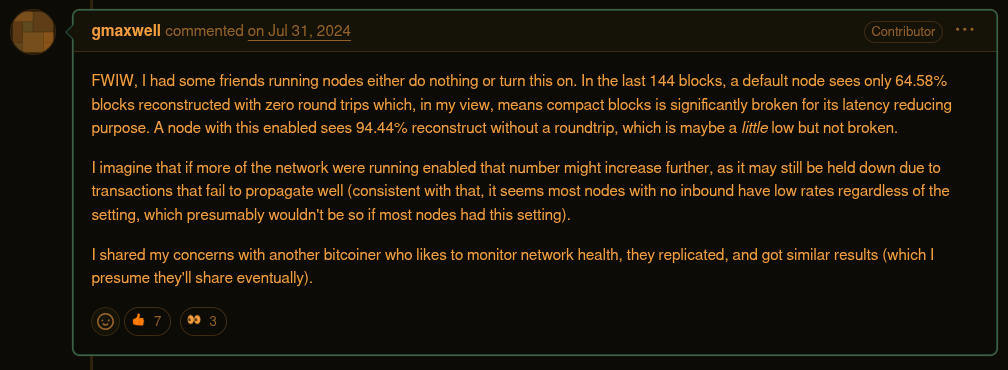

If a node didn't have full-RBF turned on it meant there were a lot more txs that it didn't know about when a new block arrives. This was causing the block reconstruction rate to be significantly lower for these nodes which degrades block propogation for the p2p network as a whole.

### Sub 1 sat/vb Summer

If you ran this notebook with the defaults, you should have noticed that my block reconstruction rate is absolutely atrocious. Way worse than the full-RBF numbers above. Something that those on the delving thread would find completely unacceptable. While monitoring the compact block logging I started to notice that there were blocks where my node was having to request thousands of txs, and every time that happened it was a block that had sub 1 sat/vb fee txs.

While I do find my terrible block reconstruction rate to be pretty fancinating, it also struck me that 99% of nodes are likely also operating this terribly since the default min relay fee is currently 1 sat/vb. There are times where it was taking more than 10 seconds to reconstruct the block because it needed to request lots of txs. This just can't be good for block propogation on the p2p network.

Currently, I am keeping my node min relay fee at 1 sat/vb just so I can have some interesting data for this topic but I will be decreasing it afterward.

### Increasing extrapool capacity

As was mentioned earlier when reviewing the different monitoring node configurations, setting `blockreconstructionextratxn=10000` in the node configuration seemed to significantly help during increased mempool activity. This option will increase the number of txs that can be kept in the extrapool from 100 to 10,000 (even an increase to 1000 would probably help). In the visualization below (originally posted to delving) its pretty stark that the alice node, which is the one that had this config set, held up much more consistently than the others (more green).

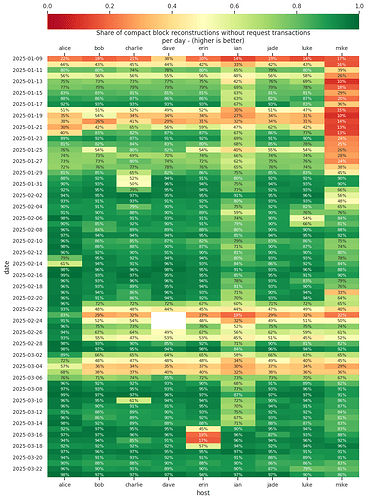

## Random Thoughts

The main thing that struck me after trying to wrap my mind around the compact block relay stuff is that if we indeed want fast block propogation, the standardness defaults are in somewhat of a hostage situation with what majority of hash rate is choosing to include in blocks. Said simply, miners will probably dictate the relaxation of default standardness rules.

Another thing that stood out to me was the suggestion of one of the comments in the Delving thread, that out-of-band txs could be to blame. Right now its a non-issue but if out-of-band txs started to pick up significant market share it would certainly also degrade block propogation.

[Bitcoin Optech Newsletter](https://bitcoinops.org/en/newsletters/2024/08/09/) also answered my question "why do people claim faster block propogation is good for small miners?"

"Faster propagation of new blocks decreases the number of accidental blockchain forks. Fewer forks reduces the amount of proof-of-work (PoW) that is wasted and reduces the number of block races that benefit larger mining pools over smaller pools, helping to make Bitcoin more secure and more decentralized."

## Special Thanks

Special thanks goes to Bitcoin Optech!! Was an invaluable resource to reference for some of the finer details of [compact block relay](https://bitcoinops.org/en/topics/compact-block-relay/) as well as some great [background](https://bitcoinops.org/en/newsletters/2024/08/09/) on the Delving thread. 